<a href="https://colab.research.google.com/github/Giraldo0712/TAM_2025_2/blob/main/Trabajo_en_clase_TAM_22_09_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo en clase 22/09/25
## Ismael Cortez Ramirez
## Santiago Alzate Serna
## Juan Camilo Giraldo Jimenez
## Mateo Palacios Lopez

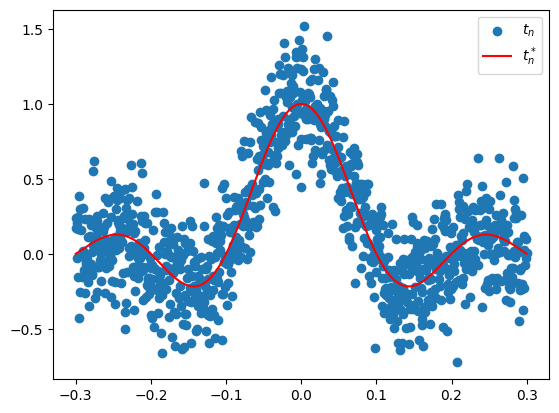

Tamaño train: 700
Tamaño test: 300


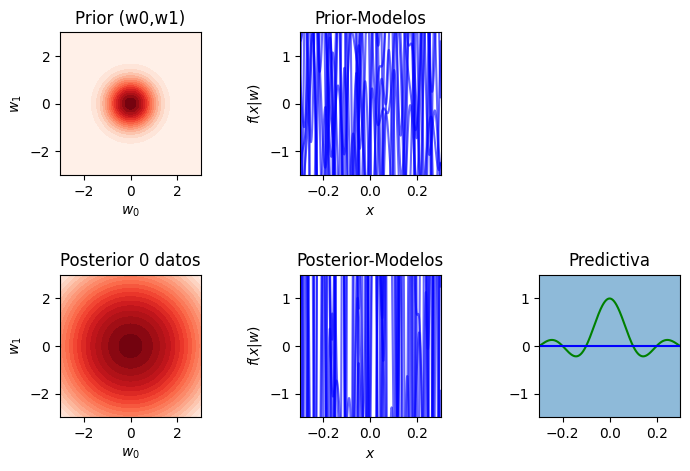

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mn
from matplotlib import animation, rc
from IPython.display import HTML

# ======= FUNCIONES AUXILIARES =======
def my_2Dpdf(mu,Sigma,axes,N=100,h=0.02,xlabel_='$w_0$',ylabel_='$w_1$',
             cmap = 'Reds',xlim=None,ylim=None):
    pdfx = mn(mu, Sigma)
    if xlim == None:
        x_min, x_max = pdfx.mean[0] - 4*pdfx.cov[0,0], pdfx.mean[0] + 4*pdfx.cov[0,0]
    else:
        x_min, x_max = xlim[0], xlim[1]
    if ylim == None:
        y_min, y_max = pdfx.mean[1] - 4*pdfx.cov[1,1], pdfx.mean[1] + 4*pdfx.cov[1,1]
    else:
        y_min, y_max = ylim[0], ylim[1]

    Xg = np.linspace(x_min, x_max, round(0.5*N))
    Yg = np.linspace(y_min, y_max, round(0.5*N))
    Xg, Yg = np.meshgrid(Xg, Yg)
    pos = np.empty(Xg.shape + (2,))
    pos[:, :, 0] = Xg
    pos[:, :, 1] = Yg
    Z = pdfx.pdf(pos)
    axes.contourf(Xg, Yg, Z, levels=20, cmap=cmap)
    axes.set_xlabel(xlabel_)
    axes.set_ylabel(ylabel_)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    return

def my_linregsyn(mu,Sigma,axes,xgrid,feature_fun,Nmod = 10,
                 xlim=[-1.2,1.2],ylim=[-1.2,1.2]):
    pdfw = mn(mu, Sigma)
    wmod = pdfw.rvs(size=Nmod)
    Phi = feature_fun(xgrid)
    t = Phi @ wmod.T
    axes.plot(xgrid,t,c='b',alpha=0.6)
    axes.set_xlabel('$x$')
    axes.set_ylabel('$f(x|w)$')
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    return

def my_posterior_update(X,t,sig_eta,sig_w,tol=1e-10):
    lambdaR = sig_eta/sig_w
    SNinv = X.T.dot(X) + lambdaR*np.eye(X.shape[1])
    val,vec = np.linalg.eigh(SNinv)
    ind = val > tol
    SN = vec[:,ind].dot(np.diag(1/val[ind])).dot(vec[:,ind].T)
    mN = np.squeeze(SN.dot(X.T.dot(t)))
    return mN,SN

def my_predictiva_update(xnew,mN,SN,sig_eta):
    mnew = xnew.dot(mN)
    signew = np.diag(sig_eta*np.eye(xnew.shape[0]) + xnew.dot(SN).dot(xnew.T))
    return mnew, signew

def var_snr(signal,snrdB):
    Ps = np.mean(signal**2)
    Pn = Ps/(10**(snrdB/10))
    return Pn

# ======= GENERACIÓN DE DATOS =======
snrdB = 5
N = 1000
A = 1.0
f0 = 5
t_axis = np.linspace(-0.3,0.3,N)

# señal sinc
tt = (A*np.sin(2*np.pi*f0*t_axis))/(2*np.pi*f0*t_axis)
tt[np.isnan(tt)] = A

sig_eta = var_snr(tt,snrdB)
t = tt + np.sqrt(sig_eta)*np.random.randn(N)

# ======= REPRESENTACIÓN FOURIER =======
def fourier_features(x, M=15):  # M = número de armónicos
    x = x.reshape(-1,1)
    Phi = [np.ones_like(x)]
    for m in range(1,M+1):
        Phi.append(np.sin(2*np.pi*m*x))
        Phi.append(np.cos(2*np.pi*m*x))
    return np.hstack(Phi)

M = 15  # número de armónicos
X = fourier_features(t_axis, M)

plt.figure()
plt.scatter(t_axis,t,label='$t_n$')
plt.plot(t_axis,tt,'r',label='$t_n^*$')
plt.legend()
plt.show()

# ======= VALIDACIÓN CRUZADA (70% train - 30% test) =======
Ntrain = int(0.7*N)
indices = np.random.permutation(N)
train_idx, test_idx = indices[:Ntrain], indices[Ntrain:]

X_train, t_train = X[train_idx], t[train_idx]
X_test, t_test = X[test_idx], t[test_idx]

print("Tamaño train:", X_train.shape[0])
print("Tamaño test:", X_test.shape[0])

# ======= PRIOR =======
mu_w = np.zeros(X.shape[1])
sig_w = 0.5
S_w = sig_w*np.eye(len(mu_w))

wxlim = [-3,3]
wylim = [-3,3]
xlim = [t_axis.min(), t_axis.max()]
ylim = [-1.5,1.5]

# ======= ANIMACIÓN =======
fig, ax = plt.subplots(2, 3,figsize=(8,5))
ax[0,2].axis('off')

def update(i):
    ax[0,0].clear(); ax[0,1].clear()
    ax[1,0].clear(); ax[1,1].clear(); ax[1,2].clear()

    # Prior
    my_2Dpdf(mu_w[:2],S_w[:2,:2],axes=ax[0,0],cmap='Reds',xlim=wxlim,ylim=wylim)
    my_linregsyn(mu_w,S_w,axes=ax[0,1],xgrid=t_axis.reshape(-1,1),
                 feature_fun=lambda x: fourier_features(x,M),xlim=xlim,ylim=ylim)

    # Posterior
    mN,SN = my_posterior_update(X_train[:i],t_train[:i],sig_eta,sig_w,tol=1e-10)
    my_2Dpdf(mN[:2],SN[:2,:2],axes=ax[1,0],cmap='Reds',xlim=wxlim,ylim=wylim)
    my_linregsyn(mN,SN,axes=ax[1,1],xgrid=t_axis.reshape(-1,1),
                 feature_fun=lambda x: fourier_features(x,M),xlim=xlim,ylim=ylim)
    ax[1,1].scatter(t_axis[:i], t_train[:i], c='r', marker='.')


    # Predictiva
    mnew,snew = my_predictiva_update(X,mN,SN,sig_eta)
    ax[1,2].plot(t_axis,tt,c='g')
    ax[1,2].scatter(t_axis[train_idx[:i]], t_train[:i], c='r', marker='.')
    ax[1,2].scatter(X_test[:,0],t_test,c='k',marker='x',alpha=0.5,label="test")
    ax[1,2].plot(t_axis,mnew,c='b')
    ii = np.argsort(t_axis)
    ax[1,2].fill_between(t_axis[ii], mnew[ii] - 2*snew[ii],
                         mnew[ii] + 2*snew[ii], alpha=0.5)
    ax[1,2].set_xlim(xlim)
    ax[1,2].set_ylim(ylim)

    # Títulos
    ax[0,0].set_title('Prior (w0,w1)')
    ax[0,1].set_title('Prior-Modelos')
    ax[1,0].set_title('Posterior ' + str(i) + ' datos')
    ax[1,1].set_title('Posterior-Modelos')
    ax[1,2].set_title('Predictiva')
    plt.subplots_adjust(wspace=0.7,hspace=0.7)

anim = animation.FuncAnimation(fig, update,
        frames=np.array([0,1,2,3,5,7,10,20,50,100,250,500]),
        blit=False)

rc('animation', html='jshtml')
anim


#  **Explicación del Código: Regresión Bayesiana con Fourier y Animación**

Este código implementa un ejemplo de **regresión bayesiana** sobre una señal tipo *sinc* con ruido. Se utiliza una representación en el dominio de Fourier como funciones base, y se muestra la evolución del **prior**, **posterior** y la **predictiva** mediante animación.

---

## 1. Librerías utilizadas
- **NumPy**: manejo de vectores y matrices.
- **Matplotlib**: visualización y animación.
- **SciPy (multivariate_normal)**: manejo de distribuciones normales multivariadas.
- **IPython.display (HTML)**: permite mostrar la animación en el notebook.

---

## 2. Funciones auxiliares
- `my_2Dpdf(mu, Sigma, axes, ...)`: dibuja la distribución normal multivariada en 2D (para los parámetros `w0, w1`).
- `my_linregsyn(mu, Sigma, axes, ...)`: genera funciones de regresión lineal muestreadas de la distribución de parámetros.
- `my_posterior_update(X, t, sig_eta, sig_w)`: calcula la media y covarianza del **posterior** de los parámetros con base en los datos.
- `my_predictiva_update(xnew, mN, SN, sig_eta)`: obtiene la media y varianza de la distribución **predictiva** para nuevos puntos.
- `var_snr(signal, snrdB)`: calcula la potencia de ruido en función de una SNR dada.

---

## 3. Generación de datos
- Se define una **señal sinc**:  
  \[
  s(t) = \frac{A \cdot \sin(2 \pi f_0 t)}{2 \pi f_0 t}
  \]
- Se añade **ruido gaussiano** en función de la SNR definida en `snrdB`.
- Se obtiene el vector de observaciones `t`.

---

## 4. Representación en Fourier
- Se define `fourier_features(x, M)` para generar un vector de características con senos y cosenos (hasta armónico `M`).
- Esto permite aproximar funciones periódicas o casi periódicas usando regresión lineal en espacio aumentado.

---

## 5. Validación cruzada
- Se divide el dataset en **70% entrenamiento** y **30% prueba**.
- `train_idx` y `test_idx` son índices aleatorios para separar los datos.

---

## 6. Prior sobre parámetros
- Media inicial de los pesos `mu_w = 0`.
- Varianza inicial `sig_w = 0.5`.
- Se representa una distribución normal multivariada en el espacio de parámetros.

---

## 7. Animación
Se actualiza en cada frame:
1. **Prior**:
   - Distribución sobre parámetros `(w0, w1)`.
   - Modelos generados a partir del prior.
2. **Posterior**:
   - Actualización de la distribución de parámetros con los datos de entrenamiento.
   - Nuevos modelos muestreados del posterior.
3. **Predictiva**:
   - Predicción sobre todo el dominio `t_axis`.
   - Banda de incertidumbre (±2 desviaciones estándar).
   - Comparación con los datos reales (`train` y `test`).

El resultado es una animación que muestra cómo la regresión bayesiana **actualiza sus creencias** a medida que se incorporan más datos.

---

## 8. Resultado esperado
- El **prior** inicial es difuso y genera funciones muy variables.
- Con más datos, el **posterior** se concentra en valores de parámetros que mejor explican la señal sinc.
- La **predictiva** se ajusta cada vez más a la señal original y reduce su incertidumbre.

---


#California Housing

In [ ]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape, housing.target.shape)
print(housing.feature_names[0:6])

(20640, 8) (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']


##Prediccion de cada feature vs precio de la casa

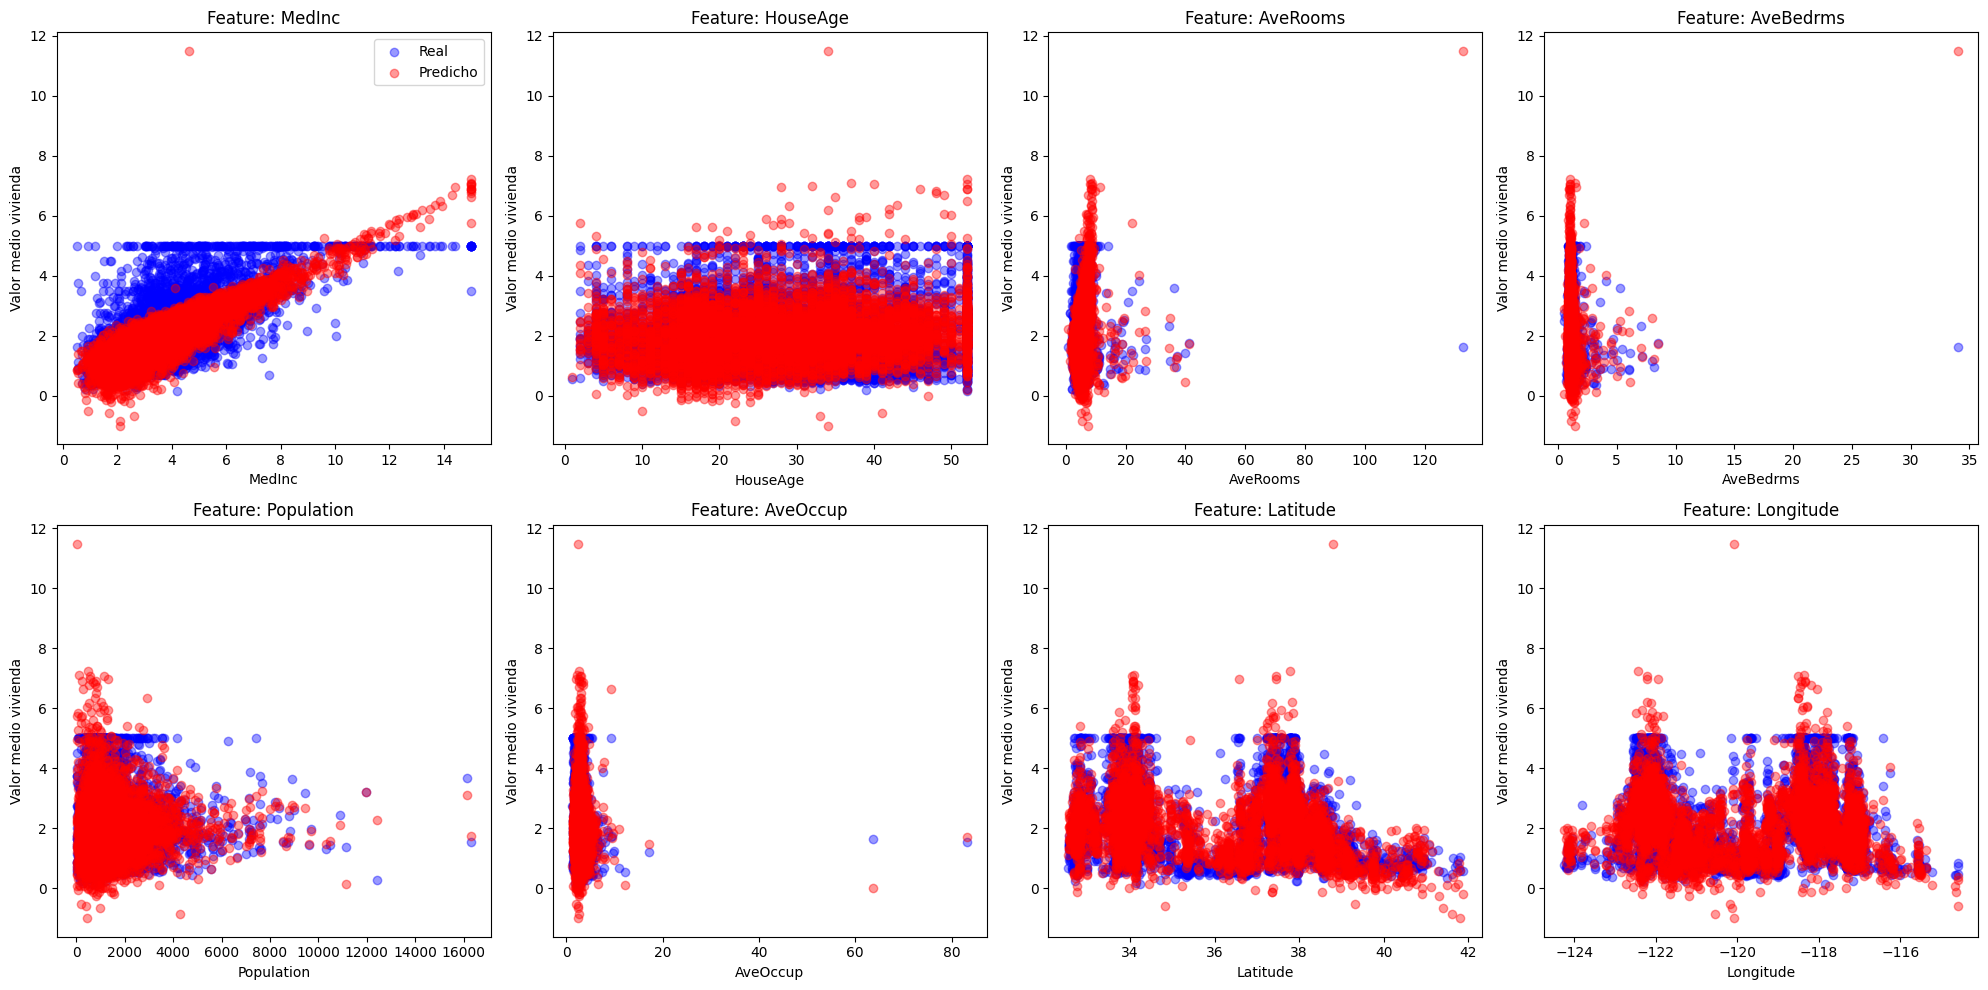

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge

# ======= CARGAR DATOS =======
housing = fetch_california_housing()
X, y = housing.data, housing.target
feature_names = housing.feature_names

# ======= TRAIN/TEST SPLIT =======
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ======= ESCALADO =======
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ======= REGRESIÓN BAYESIANA =======
model = BayesianRidge()
model.fit(X_train_scaled, y_train)

# Predicciones en test
y_pred = model.predict(X_test_scaled)

# ======= GRAFICAR =======
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()  # aplanar para iterar fácilmente

for i in range(X.shape[1]):
    ax = axes[i]
    ax.scatter(X_test[:, i], y_test, alpha=0.4, label="Real", color="blue")
    ax.scatter(X_test[:, i], y_pred, alpha=0.4, label="Predicho", color="red")
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel("Valor medio vivienda")
    ax.set_title(f"Feature: {feature_names[i]}")

# Solo agregar la leyenda una vez
axes[0].legend()
plt.tight_layout()
plt.show()


#  **Explicación del Código: Regresión Bayesiana sobre California Housing**

Este código aplica **regresión bayesiana** para predecir el valor medio de las viviendas en California, utilizando el dataset `California Housing` de **scikit-learn**.

---

## 1. Librerías utilizadas
- **scikit-learn**:
  - `fetch_california_housing`: dataset de precios de vivienda.
  - `train_test_split`: separación en entrenamiento y prueba.
  - `StandardScaler`: escalado de variables.
  - `BayesianRidge`: modelo de regresión bayesiana.
- **NumPy / Matplotlib**: procesamiento numérico y visualización.

---

## 2. Carga de datos
- Se carga el dataset con:
  ```python
  housing = fetch_california_housing()
  X, y = housing.data, housing.target
  ```
## 3. División en train/test

- Se separan los datos en 70% entrenamiento y 30% prueba con:
  ```python
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  ```

## 4. Preprocesamiento (Estandarización)

- Se escalan las variables para que todas tengan media 0 y desviación estándar
```python
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
```

## 5. Modelo: Regresión Bayesiana

- Se entrena un modelo Bayesian Ridge Regression:
  ```python
  model = BayesianRidge()
  model.fit(X_train_scaled, y_train)
  ```

- Este modelo estima los coeficientes de regresión y, además, proporciona una   medida de incertidumbre sobre ellos.

## 6. Predicciones

- Se calculan las predicciones sobre el conjunto de prueba:

  ```python
  y_pred = model.predict(X_test_scaled)
  ```

## 7. Visualización

- Se generan gráficos de dispersión para comparar:

  - Valores reales (y_test) en azul.

  - Valores predichos (y_pred) en rojo.

- Cada gráfico corresponde a una característica distinta (feature) del dataset.

El resultado muestra cómo cada variable se relaciona con el valor medio de las viviendas, permitiendo comparar el ajuste del modelo frente a los datos reales.

##Comparación entre valores reales y predicciones bayesianas

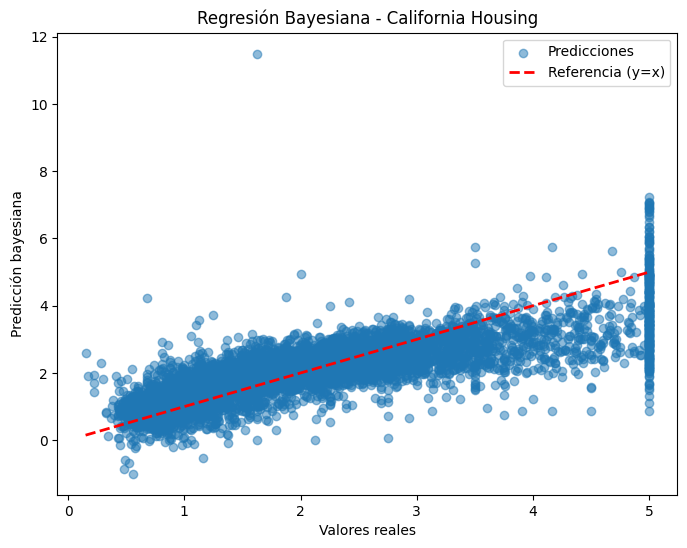

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge

# 1. Cargar dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target

# 2. Dividir en train (70%) y test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 3. Normalizar features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Modelo de regresión bayesiana
model = BayesianRidge()
model.fit(X_train, y_train)

# 5. Predicciones con el conjunto de prueba
y_pred, y_std = model.predict(X_test, return_std=True)

# 6. Graficar resultados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicciones")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label="Referencia (y=x)")
plt.xlabel("Valores reales")
plt.ylabel("Predicción bayesiana")
plt.title("Regresión Bayesiana - California Housing")
plt.legend()
plt.show()


##Relación de cada feature con el precio de la casa

Correlaciones con el precio de la casa:
MedInc        0.688075
AveRooms      0.151948
HouseAge      0.105623
AveOccup     -0.023737
Population   -0.024650
Longitude    -0.045967
AveBedrms    -0.046701
Latitude     -0.144160
Name: Target, dtype: float64


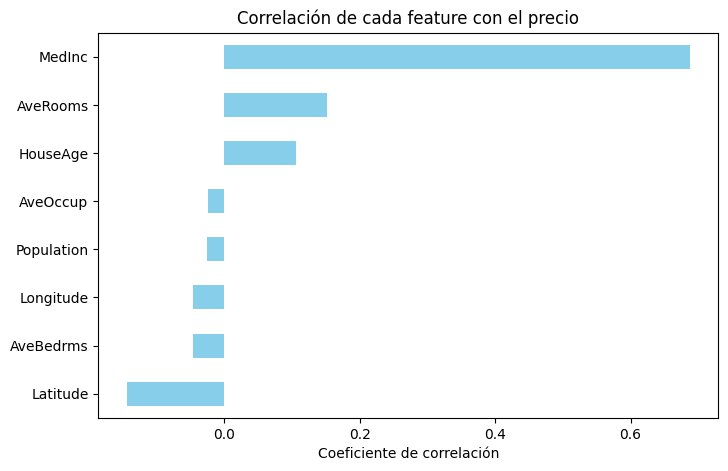

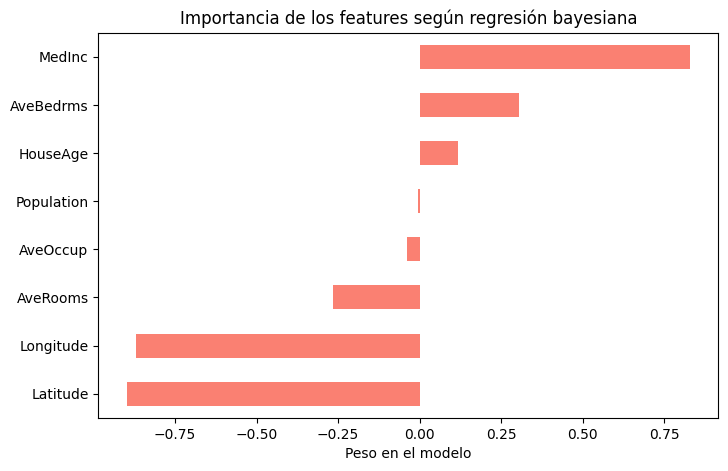

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler

# Cargar dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

# ---------- 1. Correlación de cada feature con el precio ----------
correlaciones = X.join(pd.Series(y, name="Target")).corr()["Target"].drop("Target")
print("Correlaciones con el precio de la casa:")
print(correlaciones.sort_values(ascending=False))

plt.figure(figsize=(8,5))
correlaciones.sort_values().plot(kind="barh", color="skyblue")
plt.title("Correlación de cada feature con el precio")
plt.xlabel("Coeficiente de correlación")
plt.show()

# ---------- 2. Importancia usando regresión bayesiana ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = BayesianRidge()
model.fit(X_scaled, y)

importancias = pd.Series(model.coef_, index=housing.feature_names)

plt.figure(figsize=(8,5))
importancias.sort_values().plot(kind="barh", color="salmon")
plt.title("Importancia de los features según regresión bayesiana")
plt.xlabel("Peso en el modelo")
plt.show()


# **Análisis de características e importancia con Regresión Bayesiana**

En este ejemplo se combina un **análisis estadístico simple** (correlación) con un **modelo bayesiano de regresión lineal** para estudiar qué variables del dataset *California Housing* influyen más en el precio de las viviendas.

---

## 1. Cargar dataset
```python
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target
```

## 2. Correlación de cada feature con el precio

```python
correlaciones = X.join(pd.Series(y, name="Target")).corr()["Target"].drop("Target")
```


- Se calcula el coeficiente de correlación de Pearson entre cada variable y el precio.

- Permite identificar relaciones lineales simples.

###  **Visualización**

Se muestra un gráfico de barras horizontales donde:

- Valores positivos → indican relación directa con el precio.

- Valores negativos → indican relación inversa.

## 3. Importancia usando regresión bayesiana

```python
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = BayesianRidge()
model.fit(X_scaled, y)
importancias = pd.Series(model.coef_, index=housing.feature_names)
```

- Las variables se normalizan para que todas estén en la misma escala.

- Se entrena un modelo BayesianRidge, que estima un peso para cada feature.

- Los coeficientes (model.coef_) representan la importancia relativa de cada variable en la predicción.

###  **Visualización**

Se grafican los pesos en el modelo.

- Coeficientes grandes (positivos o negativos) indican mayor influencia en el precio.

- Coeficientes pequeños sugieren poca relevancia.

### **Conclusión**

El análisis de correlación muestra relaciones lineales simples entre cada feature y el precio.

- La regresión bayesiana ofrece una visión más robusta al considerar todas las variables simultáneamente, incluyendo la regularización y la estimación de incertidumbre.

- Juntos, estos enfoques permiten identificar qué factores son más determinantes para el valor de las viviendas en California.